In [145]:
#Install these packages
#conda install -c https://conda.anaconda.org/plotly plotly
#conda install -c anaconda nltk
# import nltk
# nltk.download('all')
#conda config --append channels conda-forge
# conda install wordcloud

In [110]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import itertools
import datetime, nltk
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA


In [3]:
cust_data = pd.read_csv('data.csv',encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceNo': str})
# cust_data = pd.read_csv('data.csv',encoding="ISO-8859-1")

In [4]:
cust_data.head()


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice CustomerID         Country  
0  12/1/2010 8:26       2.55      17850  United Kingdom  
1  12/1/2010 8:26       3.39      17850  United Kingdom  
2  12/1/2010 8:26       2.75      17850  United Kingdom  
3  12/1/2010 8:26       3.39      17850  United Kingdom  
4  12/1/2010 8:26       3.39      17850  United Kingdom

In [5]:
cust_data.shape

(541909, 8)

In [6]:
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [7]:
cust_data.describe()

Quantity      UnitPrice
count  541909.000000  541909.000000
mean        9.552250       4.611114
std       218.081158      96.759853
min    -80995.000000  -11062.060000
25%         1.000000       1.250000
50%         3.000000       2.080000
75%        10.000000       4.130000
max     80995.000000   38970.000000

In [8]:
cust_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

$\sim$25% of the entries are not assigned a unique CustomerID. It is impossible to impute values for the customers without CustomerID. So we delete them from the dataframe

In [9]:
cust_data.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

In [10]:
cust_data.shape

(406829, 8)

In [11]:
# Display all columns with their datatypes and number of null values and % of null values
tab_info=pd.DataFrame(cust_data.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(cust_data.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(cust_data.isnull().sum()/cust_data.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

InvoiceNo StockCode Description Quantity InvoiceDate  \
column type         object    object      object    int64      object   
null values (nb)         0         0           0        0           0   
null values (%)          0         0           0        0           0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0          0       0  
null values (%)          0          0       0

Now we have a dataframe of features filled with 100% data 

In [12]:
print('No: of duplicates: {}'.format(cust_data.duplicated().sum()))
cust_data.drop_duplicates(inplace = True)

No: of duplicates: 5225


Checked the number of duplicates and drop the duplicate records

In [13]:
cust_data.shape

(401604, 8)

### Data Exploration

This dataframe contains 8 variables that correspond to: 

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
Description: Product (item) name. Nominal. <br>
Quantity: The quantities of each product (item) per transaction. Numeric.	<br>
InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
UnitPrice: Unit price. Numeric, Product price per unit in sterling. <br>
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
Country: Country name. Nominal, the name of the country where each customer resides.<br>



#### Countries

In [14]:
temp = cust_data[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No: of countries: {}'.format(len(countries)))
countries

No: of countries: 37


United Kingdom          19857
Germany                   603
France                    458
EIRE                      319
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                71
Portugal                   70
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan                      28
Poland                     24
Denmark                    21
Cyprus                     20
Austria                    19
Singapore                  10
Malta                      10
Unspecified                 8
Iceland                     7
USA                         7
Canada                      6
Israel                      6
Greece                      6
Czech Republic              5
European Community          5
Lithuania                   4
United Arab Emirates        3
Saudi Arabia                2
Bahrain   

In [15]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

We can see that the dataset is largely dominated by orders made from the UK.

___
#### 2.2 Customers and products

In [16]:
pd.DataFrame([{'products': len(cust_data['StockCode'].value_counts()),    
               'transactions': len(cust_data['InvoiceNo'].value_counts()),
               'customers': len(cust_data['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

products  transactions  customers
quantity      3684         22190       4372

We can see that there are 4372 customers and that they bought 3684 different products. 
The total number of transactions carried out is 22190

Now we will determine the number of products purchased in every transaction:

In [17]:
temp = cust_data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12347    562032                  22
7      12347    573511                  47
8      12347    581180                  11
9      12348    539318                  17

Based on the above table, we can see that:
- the prefix C for the InvoiceNo variable indicates transactions that have been cancelled
- Customer 12346 has bought only one product
- there are regular customers who buy a large number of items at each order

------
#### 2.2.1 Cancelling orders

Find the  the number of transactions corresponding to canceled orders:

In [18]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

CustomerID InvoiceNo  Number of products  order_canceled
0      12346    541431                   1               0
1      12346   C541433                   1               1
2      12347    537626                  31               0
3      12347    542237                  29               0
4      12347    549222                  24               0

Number of orders canceled: 3654/22190 (16.47%) 


We can see that number of cancellations is quite large ($\sim$16% of the total number of transactions).

Display the first 5 records of dataframe sorted based on CustomerID

In [19]:
display(cust_data.sort_values('CustomerID')[:5])

InvoiceNo StockCode                         Description  Quantity  \
61619     541431     23166      MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624    C541433     23166      MEDIUM CERAMIC TOP STORAGE JAR    -74215   
286623    562032     22375   AIRLINE BAG VINTAGE JET SET BROWN         4   
72260     542237     84991         60 TEATIME FAIRY CAKE CASES        24   
14943     537626     22772  PINK DRAWER KNOB ACRYLIC EDWARDIAN        12   

            InvoiceDate  UnitPrice CustomerID         Country  
61619   1/18/2011 10:01       1.04      12346  United Kingdom  
61624   1/18/2011 10:17       1.04      12346  United Kingdom  
286623    8/2/2011 8:48       4.25      12347         Iceland  
72260   1/26/2011 14:30       0.55      12347         Iceland  
14943   12/7/2010 14:57       1.25      12347         Iceland

From these lines, we can see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the Quantity and InvoiceDate variables. 

We decided to check if this is true for all the entries.

To do this, I decide to locate the entries that indicate a negative quantity and check if there is *systematically* an order indicating the same quantity (but positive), with the same description (CustomerID, Description and UnitPrice):

In [20]:
df_check = cust_data[cust_data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if cust_data[(cust_data['CustomerID'] == col[0]) & (cust_data['Quantity'] == -col[1]) 
                & (cust_data['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object


We see that the initial hypothesis **is not** fulfilled because of the existence of a  'Discount' entry. 
We check again the hypothesis but this time discarding the 'Discount' entries:

In [21]:
df_check = cust_data[(cust_data['Quantity'] < 0) & (cust_data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if cust_data[(cust_data['CustomerID'] == col[0]) & (cust_data['Quantity'] == -col[1]) 
                & (cust_data['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object


We find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

----

Now we decided to create a new variable in the dataframe that indicate if part of the order has been cancelled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were  performed before December 2010 (the point of entry of the database). Below, I make a census of the cancel orders and check for the existence of counterparts:

In [22]:
df_cleaned = cust_data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  cust_data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = cust_data[(cust_data['CustomerID'] == col['CustomerID']) &
                         (cust_data['StockCode']  == col['StockCode']) & 
                         (cust_data['InvoiceDate'] < col['InvoiceDate']) & 
                         (cust_data['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In the above function, we checked the two cases:
1. a cancel order exists without counterpart
2. there's at least one counterpart with the exact same quantity

The index of the corresponding cancel order are respectively kept in the `doubtfull_entry` and `entry_to_remove` lists whose sizes are:

In [23]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 6151
doubtfull_entry: 2607


In [24]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
# remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
# print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
# remaining_entries[:5]

#### StockCode

In [25]:
df_cleaned.StockCode.value_counts()

85123A    2023
22423     1715
85099B    1617
84879     1395
47566     1391
          ... 
90025F       1
90131        1
84016        1
90039A       1
90214U       1
Name: StockCode, Length: 3666, dtype: int64

In [26]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [27]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


There are several types of StockCode e.g. to postage or bank charges

#### Basket Price

In [28]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

InvoiceNo StockCode                         Description  Quantity  \
61619    541431     23166      MEDIUM CERAMIC TOP STORAGE JAR     74215   
72254    542237     22726          ALARM CLOCK BAKELIKE GREEN         4   
14947    537626     22805  BLUE DRAWER KNOB ACRYLIC EDWARDIAN        12   
14948    537626     22725      ALARM CLOCK BAKELIKE CHOCOLATE         4   
14949    537626     22726          ALARM CLOCK BAKELIKE GREEN         4   

           InvoiceDate  UnitPrice CustomerID         Country  \
61619  1/18/2011 10:01       1.04      12346  United Kingdom   
72254  1/26/2011 14:30       3.75      12347         Iceland   
14947  12/7/2010 14:57       1.25      12347         Iceland   
14948  12/7/2010 14:57       3.75      12347         Iceland   
14949  12/7/2010 14:57       3.75      12347         Iceland   

       QuantityCanceled  TotalPrice  
61619             74215         0.0  
72254                 0        15.0  
14947                 0        15.0  
14948                 0        15.0  
14949                 0        15.0

We can see that orders are split on several lines. We find all the purchases made during a single order to find the total price

In [29]:

temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')

temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

CustomerID InvoiceNo  Basket Price                   InvoiceDate
1      12347    537626        711.79 2010-12-07 14:57:00.000001024
2      12347    542237        475.39 2011-01-26 14:29:59.999999744
3      12347    549222        636.25 2011-04-07 10:42:59.999999232
4      12347    556201        382.52 2011-06-09 13:01:00.000000256
5      12347    562032        584.91 2011-08-02 08:48:00.000000000
6      12347    573511       1294.32 2011-10-31 12:25:00.000001280

We will try to find how the purchases are divided based on total price

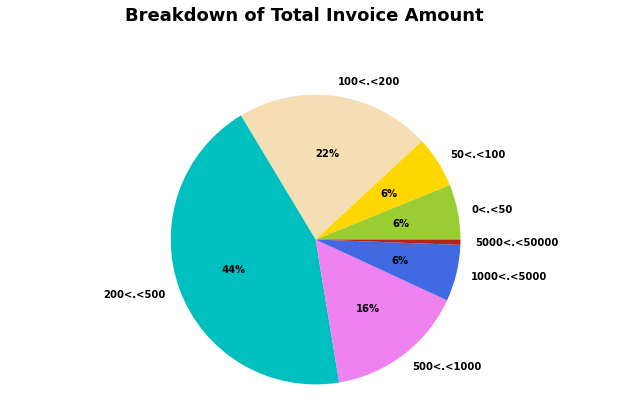

In [30]:

price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
     
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Breakdown of Total Invoice Amount", ha='center', fontsize = 18);

We can see that most of the  orders are of large purchases given that $\sim$65% of purchases give prizes in excess of $ 200

#### Product Categories
Products are uniquely identified using the StockCode column. A shrort description of the products is given in the Description variable. In this section, we try to group the products into different categories.
___
#### Products Description
First, we try to extract details from the Description variable

In [31]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, col = 'Description'):
    '''
    This function does the following operations:
    * extract the names (proper, common) appearing in the products description
    * for each name, we extract the root of the word and aggregate the set of names associated with this particular root
    * count the number of times each root appears in the dataframe
    * when several words are listed for the same root, we consider that the keyword associated with 
      this root is the shortest name (then selects the singular when there are singular/plural variants)
    '''
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  
    keywords_select = dict()  
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[col]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; root_word = stemmer.stem(t)
            if root_word in keywords_roots:                
                keywords_roots[root_word].add(t)
                count_keywords[root_word] += 1                
            else:
                keywords_roots[root_word] = {t}
                count_keywords[root_word] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("No of keywords in feature '{}': {}".format(col,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [32]:
df_products = pd.DataFrame(cust_data['Description'].unique()).rename(columns = {0:'Description'})

In [33]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

No of keywords in feature 'Description': 1484


In [34]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

We try to create a representation of the most common keywords

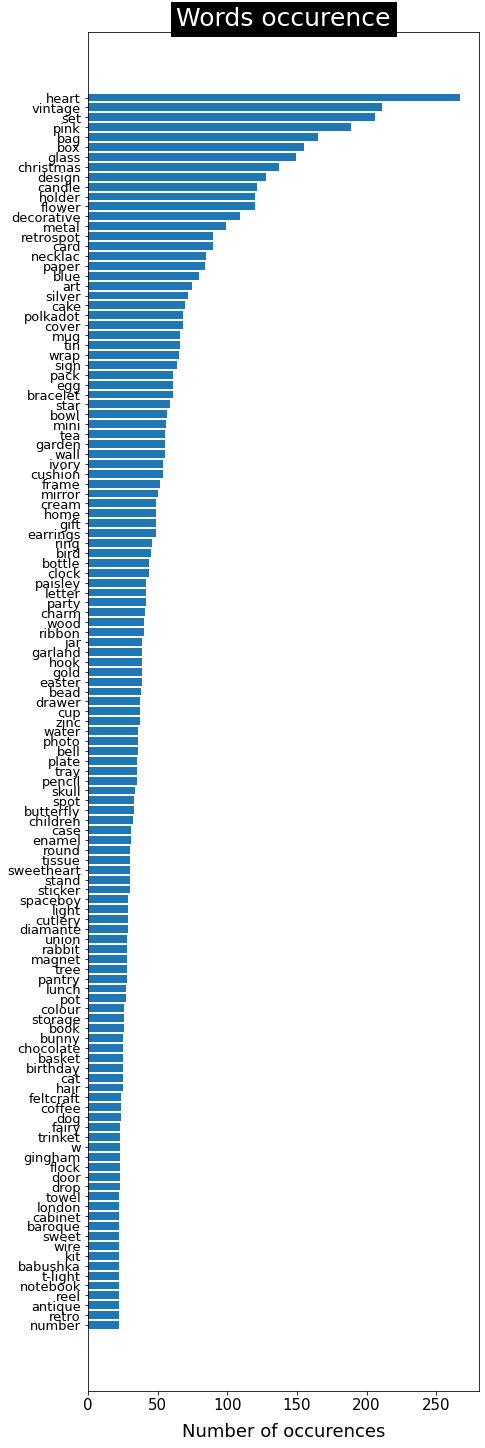

In [35]:
prod_list = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in prod_list[:125]]
x_axis = [k for k,i in enumerate(prod_list[:125])]
x_label = [i[0] for i in prod_list[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

While examinating the list, we found that some names are not helpful. Others are do not carry information, like colors. So, we discard those words from the analysis and also, we decide to consider only the words that appear more than 13 times.

In [36]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('No: of commonly used words:', len(list_products))

No: of commonly used words: 193


____
#### Data encoding

Now we will use these keywords to create groups of product. Define the $X$ matrix as:

   
|   | word 1  |  ...  | word j  | ...  | word N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise.

In [37]:
prod_list = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), prod_list))

In [38]:
X.head()

heart  vintage  set  bag  box  glass  christmas  design  candle  holder  \
0      1        0    0    0    0      0          0       0       0       1   
1      0        0    0    0    0      0          0       0       0       0   
2      1        0    0    0    0      0          0       0       0       0   
3      0        0    0    0    0      0          0       0       0       0   
4      1        0    0    0    0      0          0       0       0       0   

   ...  tidy  plant  diner  house  square  craft  lace  jewel  wallet  point  
0  ...     0      0      0      0       0      0     0      0       0      0  
1  ...     0      0      0      0       0      0     0      0       0      0  
2  ...     0      0      0      0       0      0     0      0       0      0  
3  ...     0      0      0      0       0      0     0      0       0      0  
4  ...     0      0      0      0       0      0     0      0       0      0  

[5 rows x 193 columns]

The $X$ Dataframe indicates the words contained in the description of the products using the *one-hot-encoding* principle. In practice, we have found that introducing the price range results in more balanced groups in terms of element numbers.
Hence, we add 6 extra columns to this matrix, where we indicate the price range of the products:

In [39]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(prod_list):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [40]:
X.head()

heart  vintage  set  bag  box  glass  christmas  design  candle  holder  \
0      1        0    0    0    0      0          0       0       0       1   
1      0        0    0    0    0      0          0       0       0       0   
2      1        0    0    0    0      0          0       0       0       0   
3      0        0    0    0    0      0          0       0       0       0   
4      1        0    0    0    0      0          0       0       0       0   

   ...  lace  jewel  wallet  point  0<.<1  1<.<2  2<.<3  3<.<5  5<.<10  .>10  
0  ...     0      0       0      0      0      0      1      0       0     0  
1  ...     0      0       0      0      0      0      0      1       0     0  
2  ...     0      0       0      0      0      0      0      1       0     0  
3  ...     0      0       0      0      0      0      0      1       0     0  
4  ...     0      0       0      0      0      0      0      1       0     0  

[5 rows x 199 columns]

Find the no:of products in each price range

In [41]:
print("{:<8} {:<20} \n".format('PriceRange', 'No: of Products') + 30*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

PriceRange No: of Products      
------------------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


#### Creating clusters of products

In this section, we will group the products into different classes

In [42]:
# matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10071681758064248
For n_clusters = 4 The average silhouette_score is : 0.12609893747265383
For n_clusters = 5 The average silhouette_score is : 0.1466257603527048
For n_clusters = 6 The average silhouette_score is : 0.14524437780972266
For n_clusters = 7 The average silhouette_score is : 0.14979240620319792
For n_clusters = 8 The average silhouette_score is : 0.1558201267218184
For n_clusters = 9 The average silhouette_score is : 0.14399139366685987


We found that beyond 5 clusters, some clusters contained very few elements. We therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, we iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

In [43]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.1260096732623164
For n_clusters = 5 The average silhouette_score is : 0.1466257603527048


#### Characterizing the content of clusters

In [44]:
#No:of elements in each class
pd.Series(clusters).value_counts()

3    1009
1     964
4     762
0     673
2     470
dtype: int64

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. Details are taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):
The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually

In [45]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

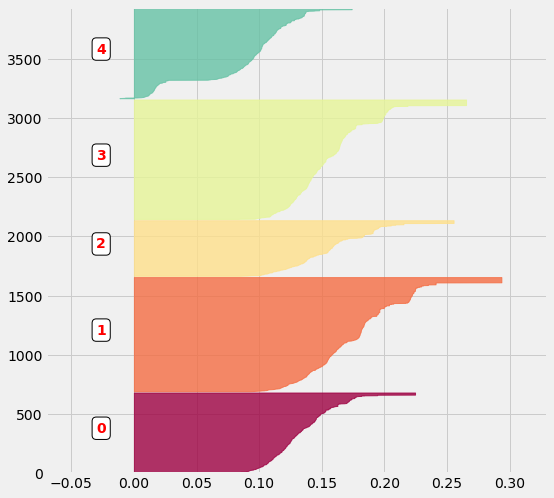

In [46]:
#____________________________________
# Define individual silouhette scores
sample_silhouette_values = silhouette_samples(X, clusters)
#__________________
# Plot the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

In order to obtain a global view of contents of the cluster, we determine which keywords are the most frequent in each of them

In [47]:
prodlist = pd.DataFrame(prod_list)
list_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    list_cluster = prodlist.loc[clusters == i]
    for word in list_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(list_cluster.loc[:, 0].str.contains(word.upper()))

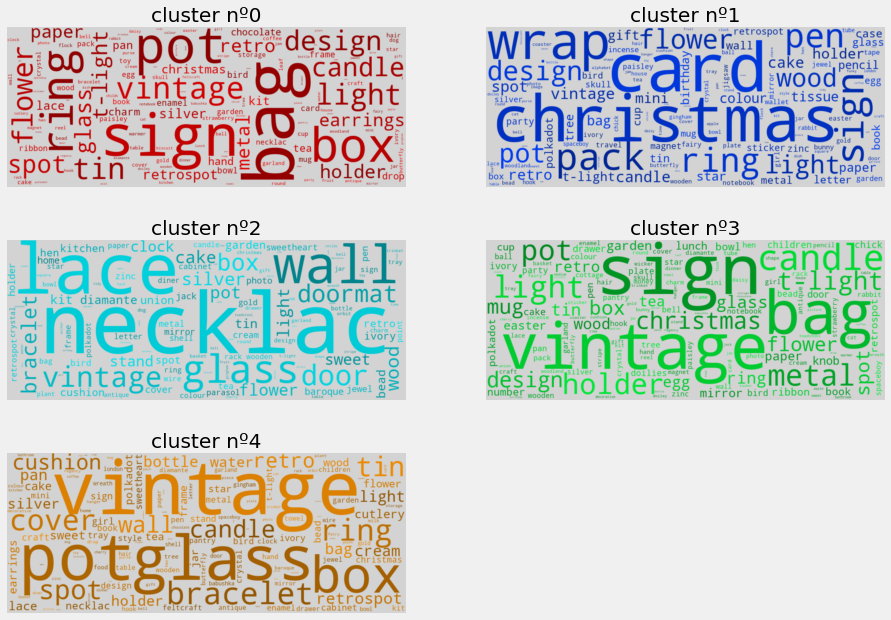

In [48]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, flower, candle, cake, ...). Another cluster would rather contain luxury items and jewelry (keywords: necklace, bracelet, lace, ...). We can also be observed that many words appear in various clusters and it is therefore difficult to clearly distinguish them.

**Principal Component Analysis**

In order to ensure that these clusters are truly distinct, we look at their composition. Given the large number of variables of the initial matrix, we first perform a PCA:

In [49]:
pca = PCA()
pca.fit(X)
pca_samples = pca.transform(X)

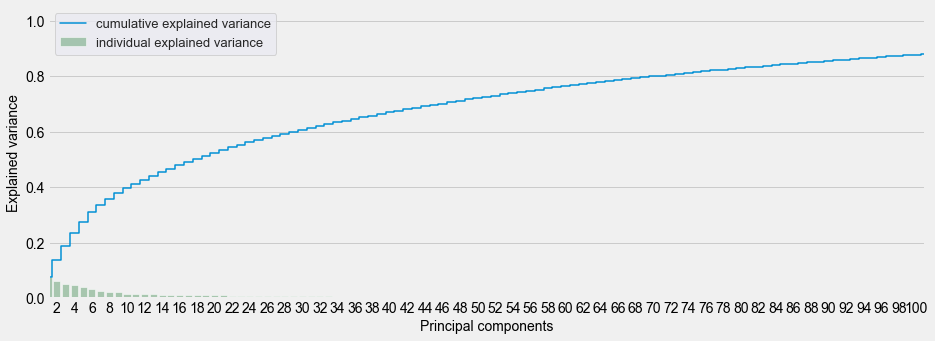

In [50]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(X.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,X.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We can see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. 
In practice, we decide to keep only a limited number of components since this decomposition is only performed to visualize the data

In [51]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(X)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

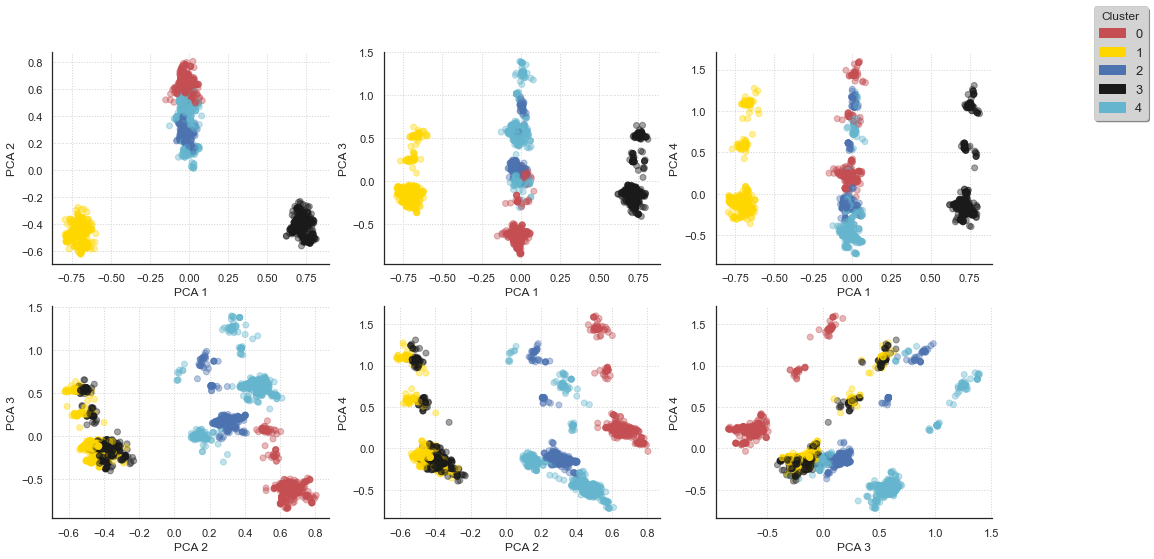

In [52]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

Now that we have grouped the different products were grouped in five clusters. We are going to add this information to the dataframe. For this purpose, we create the categorical variable categ_product where we indicate the cluster of each product :

In [53]:
corresp = dict()
for key, val in zip (prod_list, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

In [55]:
df_cleaned['categ_product'].value_counts()

3    112713
1     90107
0     80626
4     68099
2     41301
Name: categ_product, dtype: int64


#### Grouping products

Now we are creating **categ_N** variables that contains the amount spent in each product category:

In [56]:

for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

InvoiceNo                          Description  categ_product  categ_0  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER              0     15.3   
1    536365                  WHITE METAL LANTERN              4      0.0   
2    536365       CREAM CUPID HEARTS COAT HANGER              4      0.0   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE              4      0.0   
4    536365       RED WOOLLY HOTTIE WHITE HEART.              4      0.0   

   categ_1  categ_2  categ_3  categ_4  
0      0.0      0.0      0.0     0.00  
1      0.0      0.0      0.0    20.34  
2      0.0      0.0      0.0    22.00  
3      0.0      0.0      0.0    20.34  
4      0.0      0.0      0.0    20.34

Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). We decide to collect the information related to a particular order and put in in a single entry. We  therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [67]:
# Sum of the price of Products in a single purchase
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# Percentage of order price / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 

# Date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
1      12347    537626        711.79    83.40    23.40   124.44    187.2   
2      12347    542237        475.39    53.10    84.34     0.00    130.5   
3      12347    549222        636.25    71.10    81.00     0.00    330.9   
4      12347    556201        382.52    78.06    41.40    19.90     74.4   
5      12347    562032        584.91   119.70    61.30    97.80    109.7   

   categ_4                   InvoiceDate  
1   293.35 2010-12-07 14:57:00.000001024  
2   207.45 2011-01-26 14:29:59.999999744  
3   153.25 2011-04-07 10:42:59.999999232  
4   168.76 2011-06-09 13:01:00.000000256  
5   196.41 2011-08-02 08:48:00.000000000

#### Separation of data over time

The dataframe `basket_price` contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, we split the data set by retaining the first 10 months to develop the model and the following two months to test it

In [68]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [69]:
# basket_price['InvoiceDate'] = pd.to_datetime(basket_price['InvoiceDate'])
# basket_price['InvoiceDate'] = basket_price['InvoiceDate'].astype('int64')
# set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
# set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]

test_date = "2011-10-1"

set_entrainement = basket_price[basket_price['InvoiceDate'] < test_date]
set_test         = basket_price[basket_price['InvoiceDate'] >= test_date ]

basket_price = set_entrainement.copy(deep = True)


In [70]:
basket_price.head()

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
1      12347    537626        711.79    83.40    23.40   124.44    187.2   
2      12347    542237        475.39    53.10    84.34     0.00    130.5   
3      12347    549222        636.25    71.10    81.00     0.00    330.9   
4      12347    556201        382.52    78.06    41.40    19.90     74.4   
5      12347    562032        584.91   119.70    61.30    97.80    109.7   

   categ_4                   InvoiceDate  
1   293.35 2010-12-07 14:57:00.000001024  
2   207.45 2011-01-26 14:29:59.999999744  
3   153.25 2011-04-07 10:42:59.999999232  
4   168.76 2011-06-09 13:01:00.000000256  
5   196.41 2011-08-02 08:48:00.000000000

In [71]:
set_entrainement.head()

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
1      12347    537626        711.79    83.40    23.40   124.44    187.2   
2      12347    542237        475.39    53.10    84.34     0.00    130.5   
3      12347    549222        636.25    71.10    81.00     0.00    330.9   
4      12347    556201        382.52    78.06    41.40    19.90     74.4   
5      12347    562032        584.91   119.70    61.30    97.80    109.7   

   categ_4                   InvoiceDate  
1   293.35 2010-12-07 14:57:00.000001024  
2   207.45 2011-01-26 14:29:59.999999744  
3   153.25 2011-04-07 10:42:59.999999232  
4   168.76 2011-06-09 13:01:00.000000256  
5   196.41 2011-08-02 08:48:00.000000000

In [72]:
set_test.head()

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
6       12347    573511       1294.32   435.90   154.30    55.60   203.30   
7       12347    581180        224.82    55.44    38.58    30.00   100.80   
12      12349    577609       1757.55   215.22    79.32   358.35   465.86   
21      12352    574275        311.73    27.23    20.80    53.90   107.30   
27      12356    576895         58.35     0.00     0.00     0.00     0.00   

    categ_4                   InvoiceDate  
6    445.22 2011-10-31 12:25:00.000001280  
7      0.00 2011-12-07 15:52:00.000000000  
12   638.80 2011-11-21 09:51:00.000000256  
21   102.50 2011-11-03 14:36:59.999999744  
27    58.35 2011-11-17 08:40:00.000000000

____
#### Consumer Order Combinations

In a second step, we group together the different entries that correspond to the same user. We determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [73]:

# Number of customer visits and stats on the amount of the cart 
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      5  382.52  711.79  558.172000  2790.86  14.524555   
1      12348      4  227.44  892.80  449.310000  1797.24   0.000000   
2      12350      1  334.40  334.40  334.400000   334.40  27.900718   
3      12352      6  144.35  840.30  345.663333  2073.98   3.370331   
4      12353      1   89.00   89.00   89.000000    89.00  19.887640   

     categ_1    categ_2    categ_3    categ_4  
0  10.442659   8.676179  29.836681  36.519926  
1  38.016069   0.000000  41.953217  20.030714  
2  11.692584   0.000000  48.444976  11.961722  
3   0.491808  14.301006  12.892120  68.944734  
4   0.000000  22.359551  13.033708  44.719101

Finally, we define two additional variables that give the number of days elapsed since the first purchase ( FirstPurchase ) and the number of days since the last purchase ( LastPurchase ):

In [74]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      5  382.52  711.79  558.172000  2790.86  14.524555   
1      12348      4  227.44  892.80  449.310000  1797.24   0.000000   
2      12350      1  334.40  334.40  334.400000   334.40  27.900718   
3      12352      6  144.35  840.30  345.663333  2073.98   3.370331   
4      12353      1   89.00   89.00   89.000000    89.00  19.887640   

     categ_1    categ_2    categ_3    categ_4  LastPurchase  FirstPurchase  
0  10.442659   8.676179  29.836681  36.519926            59            297  
1  38.016069   0.000000  41.953217  20.030714             5            288  
2  11.692584   0.000000  48.444976  11.961722           240            240  
3   0.491808  14.301006  12.892120  68.944734             2            226  
4   0.000000  22.359551  13.033708  44.719101           134            134

A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, we find that this type of customer represents 1/3 of the customers listed:

In [76]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("No: of customers with a single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

No: of customers with a single purchase: 1448/3612  (40.09%)


#### Creation of customers categories

#### Data encoding

The dataframe `transactions_per_user` contains a summary of all the purchases that were made. Each entry in this dataframe corresponds to a particular client. We use this information to characterize the different types of customers and only keep a subset of variables:

In [77]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols]

In [78]:
matrix

count     min     max        mean    categ_0    categ_1    categ_2  \
0         5  382.52  711.79  558.172000  14.524555  10.442659   8.676179   
1         4  227.44  892.80  449.310000   0.000000  38.016069   0.000000   
2         1  334.40  334.40  334.400000  27.900718  11.692584   0.000000   
3         6  144.35  840.30  345.663333   3.370331   0.491808  14.301006   
4         1   89.00   89.00   89.000000  19.887640   0.000000  22.359551   
...     ...     ...     ...         ...        ...        ...        ...   
3607      1  180.60  180.60  180.600000  41.140642   0.000000  34.025471   
3608      1   80.82   80.82   80.820000  18.930958  18.708241   0.000000   
3609      1   98.76   98.76   98.760000  17.922236  19.349939   0.000000   
3610     10    2.50  192.80  108.683000  34.907943  17.204163   2.245061   
3611      1  765.28  765.28  765.280000  17.601401   5.315701   4.442818   

        categ_3    categ_4  
0     29.836681  36.519926  
1     41.953217  20.030714  
2     48.444976  11.961722  
3     12.892120  68.944734  
4     13.033708  44.719101  
...         ...        ...  
3607   0.000000  24.833887  
3608  20.415739  41.945063  
3609  23.238153  39.489672  
3610  36.805204   8.837629  
3611  70.680013   1.960067  

[3612 rows x 9 columns]

In [80]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62707641 261.06344186 558.12131312 378.19932449  21.15465255
  13.99491515  15.69597684  25.20174257  23.96719602]


In the following, we will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. We therefore perform a PCA beforehand:

In [81]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

Check the amount of variance explained by each of the components:

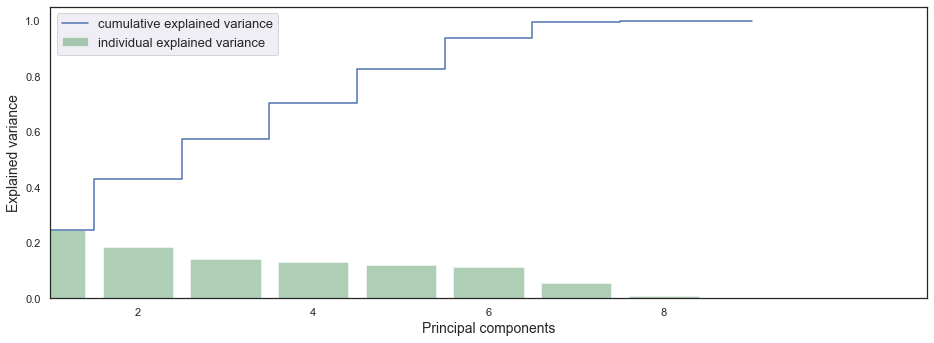

In [82]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

#### Creation of customer categories

We define clusters of clients from the standardized matrix that was defined earlier and using the `k-means` algorithm from` scikit-learn`. We choose the number of clusters based on the silhouette score and we find that the best score is obtained with 11 clusters:

In [84]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette_score: {:<.3f}'.format(silhouette_avg))

silhouette_score: 0.214


In [86]:
#No:of Customers in each cluster
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['No: of Customers']).T

9    8    5    4    3    0    1    7   10  2   6 
No: of Customers  1468  455  434  365  264  262  190  147  12   8   7

There is a certain disparity in the sizes of different groups that have been created. Hence we will now try to understand the content of these clusters in order to validate (or not) this particular separation. We use the result of the PCA:

In [87]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

Plot the various clusters

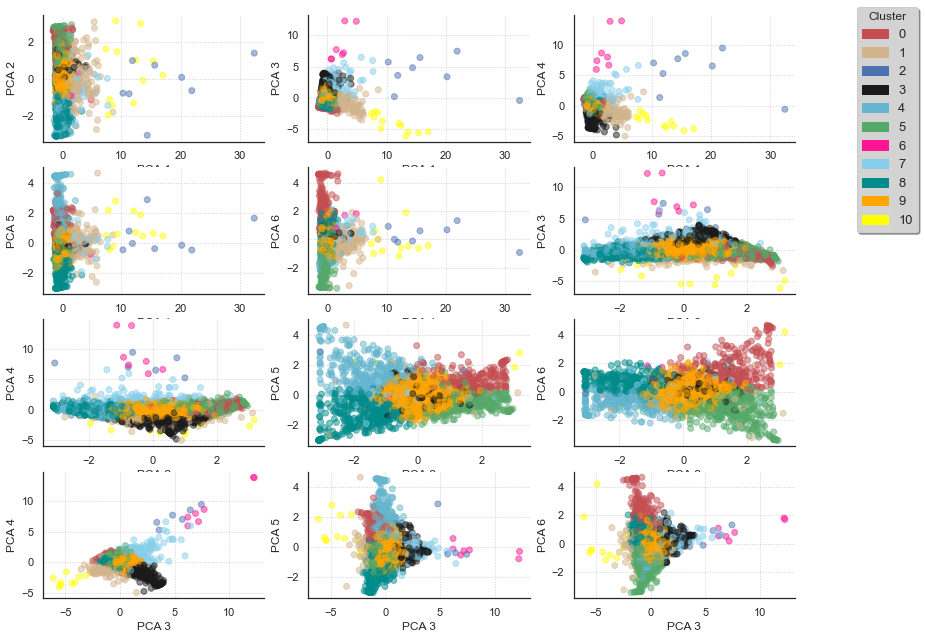

In [88]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

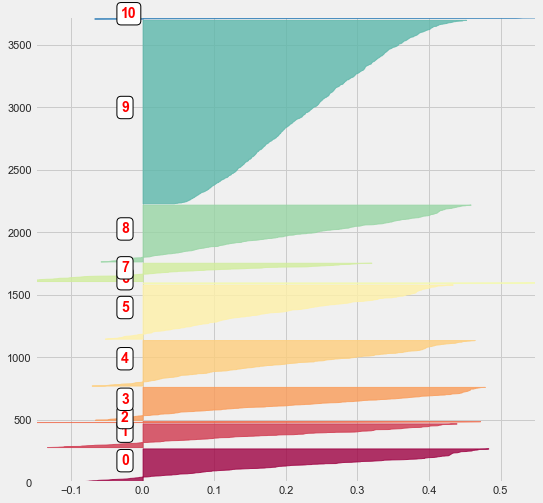

In [91]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

# Plot the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

We need to understand the habits of the customers in each cluster. To do so, we start by adding to the `selected_customers` dataframe a variable that defines the cluster to which each client belongs:

In [92]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, we average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. We also determine the number of clients in each group (variable ** size **):

In [94]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('Number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

Number of customers: 3612


Finally, we re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount spent in each product category and then, according to the total amount spent:

In [95]:
list_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    list_index.append(merged_df[merged_df[column] > 45].index.values[0])
#___________________________________
list_index_reordered = list_index
list_index_reordered += [ s for s in merged_df.index if s not in list_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = list_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

cluster      count          min           max         mean            sum  \
0       3.0   2.602273   209.689167    381.333636   291.392547     832.416023   
1       0.0   2.221374   192.703053    318.645573   247.588209     590.533206   
2       4.0   2.531507   195.527838    316.260274   249.603435     656.181071   
3       5.0   2.403226   215.736336    323.856131   267.130161     654.162122   
4       8.0   2.263736   212.155473    358.108857   276.792722     711.056681   
5       9.0   3.339918   217.642542    462.069660   330.534045    1112.761465   
6       1.0   1.694737  1040.230421   1401.764005  1204.610447    2173.407163   
7      10.0   1.750000  3482.720833   3975.275000  3687.645056    6129.364167   
8       7.0  18.707483    85.003333   1730.243810   595.800862   10562.048299   
9       6.0  92.428571    12.191429   1861.862857   379.837161   35626.825714   
10      2.0  24.000000   508.816250  19139.158750  5335.811770  100981.552500   

      categ_0    categ_1    categ_2    categ_3    categ_4  size  
0   62.792889   6.947467   6.896455  14.292667   9.098054   264  
1   11.389386  55.141260   5.454375  19.732415   8.282564   262  
2   11.890336   5.406421  51.293763  11.989984  19.435405   365  
3   12.640780  11.876373   6.144624  58.113187  11.228466   434  
4   11.865240   5.207583  13.125019  10.998034  58.840437   455  
5   22.649024  13.797695  14.074938  26.170433  23.313791  1468  
6   21.742582  12.139502  13.802962  26.261056  26.054254   190  
7   13.149528  22.755325  18.122932  19.957736  26.014478    12  
8   25.354678  12.125785  15.589980  23.577492  23.386014   147  
9   22.598675  13.044252  17.784155  25.695294  20.903597     7  
10  25.190974   7.870895  20.627523  23.864624  23.365118     8

#### Classification of customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, we will test several classifiers implemented in scikit-learn

In [101]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, we only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [103]:

columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

Finally, we split the dataset in train and test sets:

In [104]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

### Support Vector Machine Classifier (SVC)

In [107]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)
svc.grid_predict(X_test, Y_test)

Precision: 86.72 % 


####  Confusion matrix
We use the code from [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [111]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


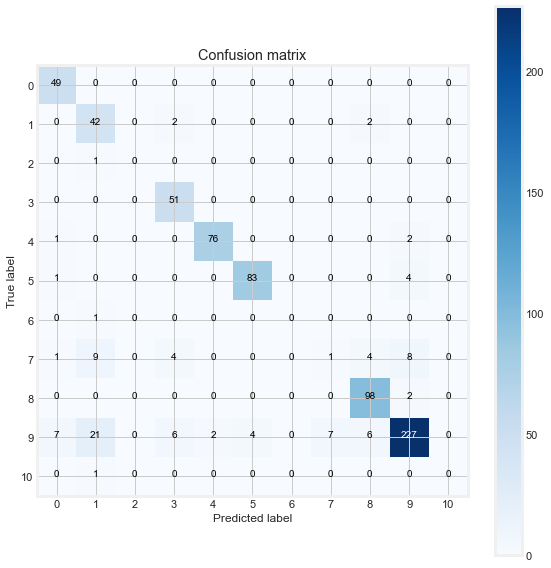

In [112]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

#### Learning curve

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample. We use the [scikit-learn documentation code again](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr- self-examples-model-selection-pad-learning-curve-py)

In [113]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

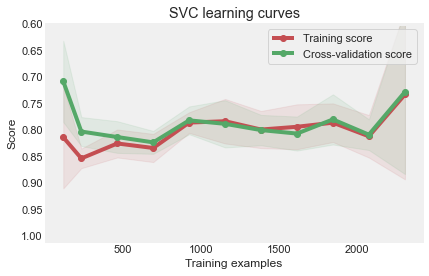

In [115]:
#Plot the learning curve of the SVC classifier
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

___
### Logistic Regression


In [116]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 91.01 % 


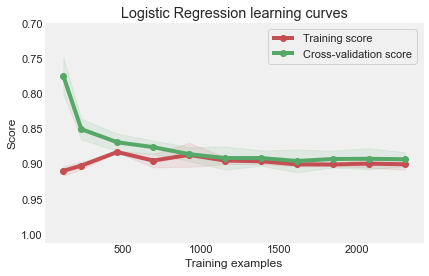

In [117]:
#Plot learning curve of Logistic Regression Classifier
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### k-Nearest Neighbors

In [118]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 81.88 % 


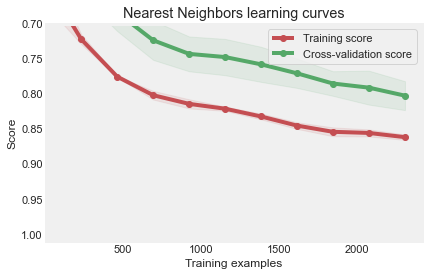

In [119]:
#plot the learning curve of k-Nearest Neighbors
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Decision Tree

In [120]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 84.09 % 


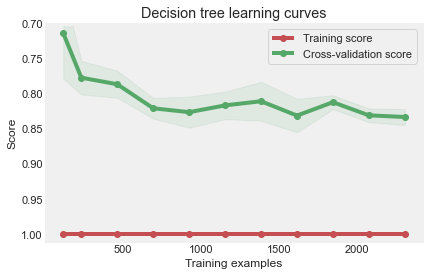

In [121]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Random Forest Classifier

In [122]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 91.15 % 


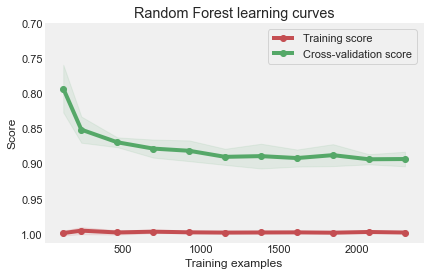

In [123]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### AdaBoost Classifier

In [124]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 50.07 % 


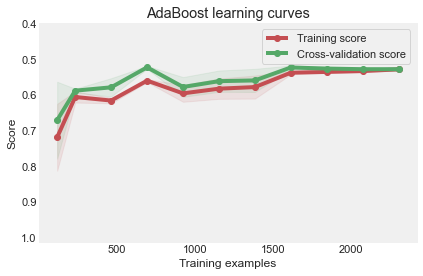

In [125]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Gradient Boosting Classifier

In [126]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)


Precision: 91.01 % 


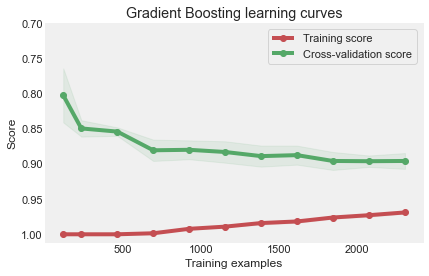

In [127]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Select the model

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, I use the `VotingClassifier` method of the `sklearn` package. As a first step, we adjust the parameters of the various classifiers using the *best* parameters previously found:

In [128]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Define a classifier that merges the results of the various classifiers

In [131]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft') 
votingC = votingC.fit(X_train, Y_train)
#Create a prediction for this model
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 91.15 % 


#### Testing predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 10 months. In this section,we test the model  the last two months of the dataset, that has been stored in the `set_test` dataframe:

In [132]:
basket_price = set_test.copy(deep = True)

In a first step, we regroup the data according to the same procedure as used on the training set. However, we are correcting the data to take into account the difference in time between the two datasets and weights the variables ** count ** and ** sum ** to obtain an equivalence with the training set:

In [133]:

transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count      min      max     mean       sum    categ_0  \
0      12347     10   224.82  1294.32   759.57   7595.70  32.343299   
1      12349      5  1757.55  1757.55  1757.55   8787.75  12.245455   
2      12352      5   311.73   311.73   311.73   1558.65   8.735123   
3      12356      5    58.35    58.35    58.35    291.75   0.000000   
4      12357      5  6207.67  6207.67  6207.67  31038.35  14.684737   

     categ_1    categ_2    categ_3     categ_4  
0  12.696657   5.634767  20.017905   29.307371  
1   4.513101  20.389178  26.506216   36.346050  
2   6.672441  17.290604  34.420813   32.881019  
3   0.000000   0.000000   0.000000  100.000000  
4   5.089832  25.189000  18.475531   36.560900

In [143]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
X_test = transactions_per_user[list_cols]
scaled_X_test = scaler.transform(X_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. ** At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself**. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables ** count **, ** min **, ** max ** and ** sum **). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the `kmeans` method used in section 4. The` predict` method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories:

In [144]:
Y = kmeans.predict(scaled_X_test)

In [141]:
#Select required features

columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]

for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)



______________________________ 
Support Vector Machine
Precision: 70.96 % 
______________________________ 
Logostic Regression
Precision: 75.12 % 
______________________________ 
k-Nearest Neighbors
Precision: 68.42 % 
______________________________ 
Decision Tree
Precision: 69.32 % 
______________________________ 
Random Forest
Precision: 75.35 % 
______________________________ 
Gradient Boosting
Precision: 75.82 % 


it is possible to improve the quality of the classifier by combining their respective predictions. 
At this level, I chose to mix *Random Forest*, *Gradient Boosting* and 
*k-Nearest Neighbors* predictions because this leads to a slight improvement in predictions:

In [142]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 76.53 % 


## Conclusion

The work described in this notebook is based on a database providing details on purchases made on an E-commerce platform over a period of one year. Each entry in the dataset describes the purchase of a product, by a particular customer and at a given date. In total, approximately $\sim$4000 clients appear in the database. Given the available information, I decided to develop a classifier that allows to anticipate the type of purchase that a customer will make, as well as the number of visits that he will make during a year, and this from its first visit to the E-commerce site.

The first stage of this work consisted in describing the different products sold by the site, which was the subject of a first classification. There, I grouped the different products into 5 main categories of goods. In a second step, I performed a classification of the customers by analyzing their consumption habits over a period of 10 months. I have classified clients into 11 major categories based on the type of products they usually buy, the number of visits they make and the amount they spent during the 10 months. Once these categories established, I finally trained several classifiers whose objective is to be able to classify consumers in one of these 11 categories and this from their first purchase. For this, the classifier is based on 5 variables which are:
- ** mean **: amount of the basket of the current purchase
- ** categ_N ** with $N \in [0: 4]$: percentage spent in product category with index $N$

Finally, the quality of the predictions of the different classifiers was tested over the last two months of the dataset. The data were then processed in two steps: first, all the data was considered (ober the 2 months) to define the category to which each client belongs, and then, the classifier predictions were compared with this category assignment. I then found that 75% of clients are awarded the right classes.
The performance of the classifier therefore seems correct given the potential shortcomings of the current model. In particular, a bias that has not been dealt with concerns the seasonality of purchases and the fact that purchasing habits will potentially depend on the time of year (for example, Christmas ). In practice, this seasonal effect may cause the categories defined over a 10-month period to be quite different from those extrapolated from the last two months. In order to correct such bias, it would be beneficial to have data that would cover a longer period of time.